In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from datetime import date
import hisepy
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import scanpy as sc
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

## Helper functions

In [2]:
def cache_uuid_path(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [3]:
def read_csv_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_csv(cache_file)
    return res

In [4]:
def read_parquet_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_parquet(cache_file)
    return res

In [5]:
def read_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file)
    return res

In [6]:
def backed_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file, backed = 'r')
    return res

In [7]:
def rm_cache_uuid(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    rm_call = 'rm -r {d}'.format(d = cache_path)
    os.system(rm_call)

In [8]:
def format_cell_type(cell_type):
    cell_type = re.sub('\\+', 'pos', cell_type)
    cell_type = re.sub('-', 'neg', cell_type)
    cell_type = re.sub(' ', '_', cell_type)
    return cell_type

In [9]:
def filename_cell_type(filename):
    cell_type = re.sub('.+L3_','',filename)
    cell_type = re.sub('_2024.+','',cell_type)
    cell_type = re.sub('_', ' ', cell_type)
    cell_type = re.sub('pos','+', cell_type)
    cell_type = re.sub('neg','-', cell_type)
    return cell_type

In [10]:
def element_id(n = 3):
    import periodictable
    from random import randrange
    rand_el = []
    for i in range(n):
        el = randrange(0,118)
        rand_el.append(periodictable.elements[el].name)
    rand_str = '-'.join(rand_el)
    return rand_str

In [11]:
def cluster_means(adata, clusters):
    obs_clusters = adata.obs.groupby(clusters)
    
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(obs_clusters)), dtype=np.float64),
        columns = list(obs_clusters.groups.keys()),
        index = adata.var.index
    )

    for group, idx in obs_clusters.indices.items():
        X = adata.X[idx]
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

In [12]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

## Markers for dotplots

In [13]:
broad_markers = [
    'CD3D', # T cells
    'CD3E', # T cells/NK
    'FCN1', # Monocytes/Myeloid
    'HBB', # Erythrocytes
    'MS4A1', # B cells
    'CD79A', # B cells
    'PPBP', # Platelets
    'IFI44L' # ISG-high
]

In [14]:
class_markers = [
    'CD4',
    'CD8A',
    'CD27',
    'GZMB',
    'IFI44L',
    'KLRF1',
    'SOX4'
]

## Read cell type hierarchy

In [15]:
hierarchy_uuid = '1a44252c-8cab-4c8f-92c9-d8f3af633790'
hierarchy_df = read_csv_uuid(hierarchy_uuid)

## Identify files for use in HISE

In [16]:
search_id = 'yttrium-lutetium-gallium'

Retrieve files stored in our HISE project store

In [17]:
ps_df = hisepy.list_files_in_project_store('cohorts')
ps_df = ps_df[['id', 'name']]

Filter for files from the previous notebook using our search_id

In [18]:
search_df = ps_df[ps_df['name'].str.contains(search_id)]
search_df = search_df.sort_values('name')
search_df['AIFI_L3'] = [filename_cell_type(f) for f in search_df['name']]

In [19]:
search_df['AIFI_L3'].tolist()

['CM CD4 T cell',
 'Core naive CD4 T cell',
 'GZMB- CD27- EM CD4 T cell',
 'GZMB- CD27+ EM CD4 T cell',
 'ISG+ memory CD4 T cell',
 'ISG+ naive CD4 T cell',
 'KLRF1- GZMB+ CD27- memory CD4 T cell',
 'SOX4+ naive CD4 T cell']

## Review CM CD4 T cell

In [20]:
cell_type = 'CM CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [21]:
type_uuid

'38827e4d-4b66-43eb-9d5a-1e749ffc38d2'

In [22]:
adata = read_adata_uuid(type_uuid)

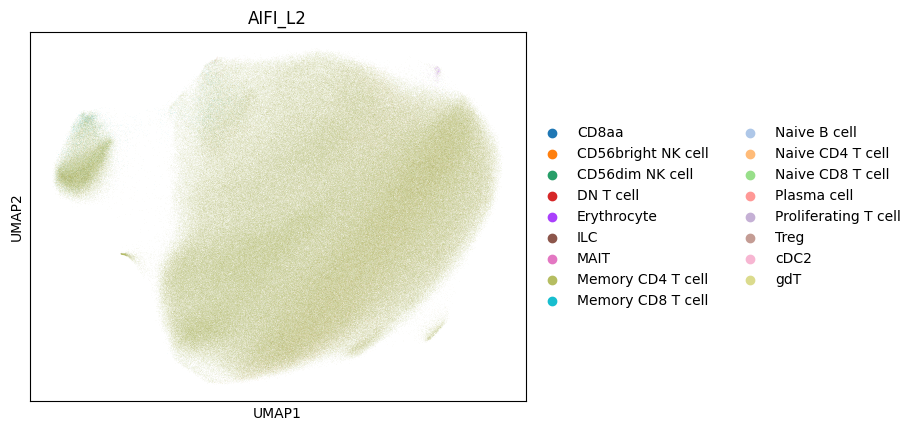

In [23]:
sc.pl.umap(adata, color = 'AIFI_L2')

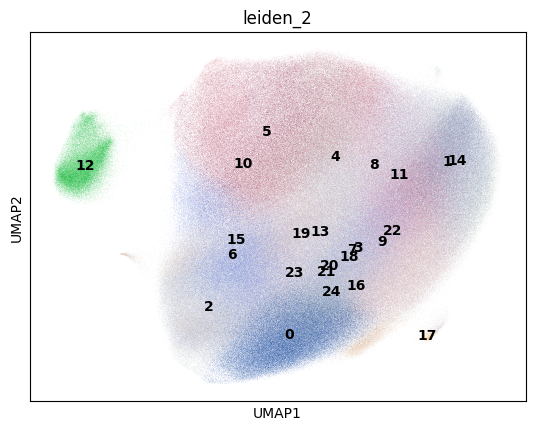

In [24]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

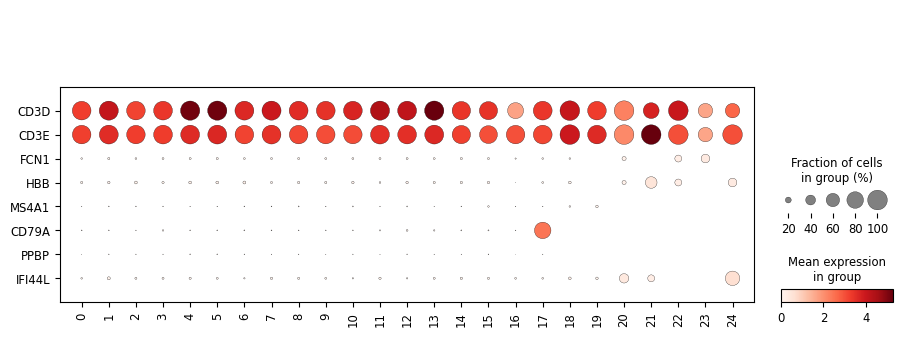

In [25]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

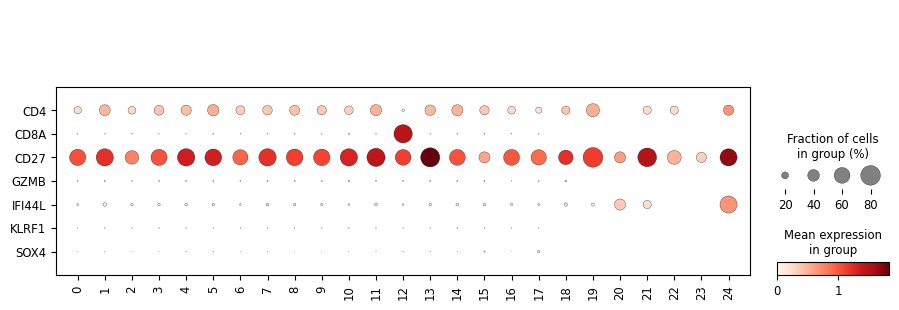

In [26]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

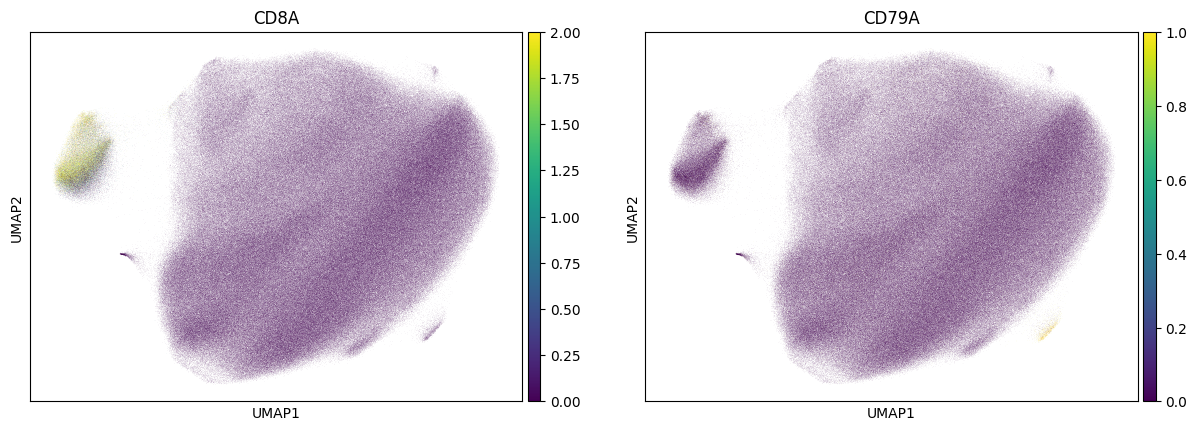

In [27]:
sc.pl.umap(adata, color = ['CD8A','CD79A'], vmax = 'p99')

In [28]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     133926
1     126841
2     122776
3     118223
4     106020
5     104032
6     102431
7      99590
8      88510
9      76124
10     67655
11     66953
12     62120
13     45739
14     37829
15     36254
16     28456
17      1054
18        28
19        15
20         8
21         4
22         4
23         3
24         3
Name: count, dtype: int64

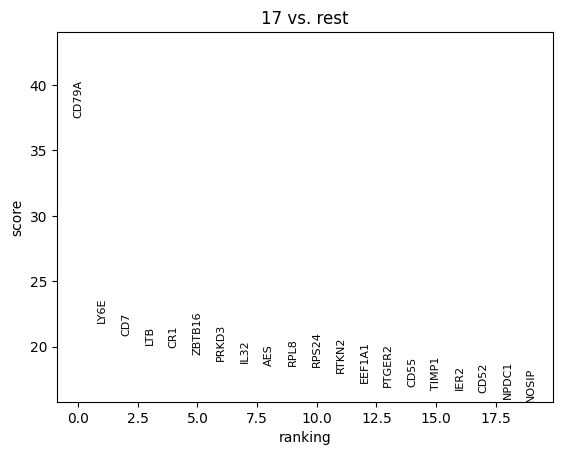

In [29]:
sc.tl.rank_genes_groups(
    adata, 
    groupby = 'leiden_2', 
    groups = ['17']
)
sc.pl.rank_genes_groups(adata)

## Review Core naive CD4 T cell

In [30]:
cell_type = 'Core naive CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [31]:
type_uuid

'c1a418fe-1bd0-49f1-b9b5-47916d239ca9'

In [ ]:
adata = read_adata_uuid(type_uuid)

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

In [ ]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

In [ ]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

In [ ]:
sc.pl.umap(adata, color = ['CD27','IGHM'], vmax = 'p99')

In [ ]:
adata.obs['leiden_2'].value_counts()

In [ ]:
sc.tl.rank_genes_groups(
    adata, 
    groupby = 'leiden_2', 
    groups = ['7','14']
)
sc.pl.rank_genes_groups(adata)

In [ ]:
sc.pl.umap(adata, color = ['TCL1A','YBX3'], vmax = 'p99')

## Review GZMB- CD27- EM CD4 T cell

In [ ]:
cell_type = 'GZMB- CD27- EM CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [ ]:
type_uuid

In [ ]:
adata = read_adata_uuid(type_uuid)

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

In [ ]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

In [ ]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

In [ ]:
sc.pl.umap(adata, color = ['CD27','IGHM'], vmax = 'p99')

In [ ]:
adata.obs['leiden_2'].value_counts()

In [ ]:
sc.tl.rank_genes_groups(
    adata, 
    groupby = 'leiden_2', 
    groups = ['6','16']
)
sc.pl.rank_genes_groups(adata)

In [ ]:
sc.pl.umap(adata, color = ['S100A10','TCL1A'], vmax = 'p99')

## Review GZMB- CD27+ EM CD4 T cell

In [ ]:
cell_type = 'GZMB- CD27+ EM CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [ ]:
type_uuid

In [ ]:
adata = read_adata_uuid(type_uuid)

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

In [ ]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

In [ ]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

In [ ]:
sc.pl.umap(adata, color = ['FAS','IGHM'], vmax = 'p99', size = 12)

In [ ]:
adata.obs['leiden_2'].value_counts()

In [ ]:
sc.tl.rank_genes_groups(
    adata, 
    groupby = 'leiden_2', 
    groups = ['1','13','15']
)
sc.pl.rank_genes_groups(adata)

In [ ]:
sc.pl.umap(adata, color = ['PLAC8','FOXP1','CFL1'], vmax = 'p99')

## Review ISG+ memory CD4 T cell

In [ ]:
cell_type = 'ISG+ memory CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [ ]:
type_uuid

In [ ]:
adata = read_adata_uuid(type_uuid)

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

In [ ]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

In [ ]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

In [ ]:
sc.tl.rank_genes_groups(
    adata, 
    groupby = 'leiden_2', 
    groups = ['17','19']
)
sc.pl.rank_genes_groups(adata)

In [ ]:
sc.pl.umap(adata, color = ['IGLC6','TCL1A'], vmax = 'p99')

In [ ]:
sc.tl.rank_genes_groups(
    adata, 
    groupby = 'leiden_2', 
    groups = ['16'],
    reference = '1',
    method = 'wilcoxon'
)
sc.pl.rank_genes_groups(adata)

In [ ]:
sc.pl.umap(adata, color = ['JUN'], vmax = 'p99')

## Review ISG+ naive CD4 T cell

In [ ]:
cell_type = 'ISG+ naive CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [ ]:
type_uuid

In [ ]:
adata = read_adata_uuid(type_uuid)

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

In [ ]:
sc.pl.umap(adata, color = 'batch_id', legend_loc = 'on data')

In [ ]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

In [ ]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

In [ ]:
sc.tl.rank_genes_groups(
    adata, 
    groupby = 'leiden_2', 
    groups = ['10','12','13','14']
)
sc.pl.rank_genes_groups(adata, ncols = 2)

In [ ]:
sc.pl.umap(adata, color = ['AIM2','LYZ','IGLC6'], vmax = 'p99', ncols = 2)

## Review KLRF1- GZMB+ CD27- memory CD4 T cell

In [ ]:
cell_type = 'KLRF1- GZMB+ CD27- memory CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [ ]:
type_uuid

In [ ]:
adata = read_adata_uuid(type_uuid)

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

In [ ]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

In [ ]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

In [ ]:
sc.tl.rank_genes_groups(
    adata, 
    groupby = 'leiden_2', 
    groups = ['19']
)
sc.pl.rank_genes_groups(adata)

In [ ]:
sc.pl.umap(adata, color = ['IGLC6'], vmax = 'p99', ncols = 2)

## Review SOX4+ naive CD4 T cell

In [ ]:
cell_type = 'SOX4+ naive CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [ ]:
type_uuid

In [ ]:
adata = read_adata_uuid(type_uuid)

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

In [ ]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

In [ ]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

In [ ]:
sc.tl.rank_genes_groups(
    adata, 
    groupby = 'leiden_2', 
    groups = ['14']
)
sc.pl.rank_genes_groups(adata)

In [ ]:
sc.pl.umap(adata, color = ['IGLC6'], vmax = 'p99', ncols = 2)